In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle
from numpy.lib.stride_tricks import as_strided

### Configuration

In [2]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir="../../original_images/SD"
base_model = 'SD/sd_01_.ckpt'
model_20000 = 'SD/sd_20000.ckpt'
model_30000 = 'SD/sd_30000.ckpt'
model_40000 = 'SD/sd_40000.ckpt'
model_50000 = 'SD/sd_50000.ckpt'

connected_model = 'SD/sd_conected.ckpt'

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 2000             # Number of neurons in fully-connected layer.

### Load Data

In [3]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir):
        list_of_imgs = []
        list_of_labels = []
        for img in os.listdir(img_dir):
            img_path = os.path.join(img_dir, img)
            for img_label in os.listdir(img_path):
                img_data = os.path.join(img_path, img_label)
                if img_label == "img":
#                     print(img_data + "/img.png")
                    list_of_imgs.append(img_data + "/img.png")
                else:
                        list_of_labels.append([os.path.join(img_data, label) for label in os.listdir(img_data)])

        data_imgs = np.array(list_of_imgs)
        data_labels = np.array(list_of_labels)

        return data_imgs, data_labels


# def load_data(img_dir, label):
#         list_of_imgs = []
#         list_of_labels = []
#         for img in os.listdir(img_dir):
#                 img = os.path.join(img_dir, img)
# #                 print(img)
#                 if not img.endswith(".png"):
#                         continue

#                 list_of_imgs.append(img)
#                 list_of_labels.append(label)
#         data_labels = np.asarray(list_of_labels, dtype=np.int32)
#         data_imgs = np.array(list_of_imgs)
# #         data_labels = np.array(list_of_labels)
#         return data_imgs, data_labels
    
def get_batch_images(data, label, rshp):
        list_of_imgs = []
        list_of_labels = []
        for img, lbl in zip(data, label):
            orig_img = cv2.imread(img)
            #only first image as a label
            orig_lbl = cv2.imread(lbl[0])
            if orig_img is None or orig_lbl is None:
                    print ("Unable to read image{} or {}".format(img, lbl))
                    continue
            
            flattened_img = orig_img.flatten()
            flattened_lbl = orig_lbl.flatten()

            list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
            list_of_labels.append(np.asarray(flattened_lbl, dtype=np.float32))

        data_labels = np.array(list_of_labels)
        reshaped_labels = np.reshape(data_labels, rshp)
        data_labels = np.squeeze(reshaped_labels[:, :, :1])
#         print(data_labels.shape)
        data_imgs = np.array(list_of_imgs)

        
        return data_imgs, data_labels

### Next Batch Own Implementation

In [4]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [5]:
# We know that images are 60 pixels in each dimension.
# img_size = 8 * 4

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 4 * 4

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (4, 4, num_channels)


# Number of classes, one class for same or different image
num_classes = 4*4
patch_size = (2, 2)

### Image Plot Functions

In [6]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['train','val'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Helper Functions for TF Graph Initialization

In [7]:
def new_weights(shape, layer_name):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=layer_name+'_W')

def new_bias(length, layer_name):
    return tf.Variable(tf.constant(0.05, shape=[length]), name=layer_name+'_b')

### Helper Functions for Network

In [8]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   name_scope,
                   layer_name='',
                   use_pooling=True):

    with tf.name_scope(name_scope):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = new_weights(shape, layer_name)
        biases = new_bias(num_filters, layer_name)

        layer = tf.add(tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME'), biases, name=layer_name)

        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 3, 3, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME', name=layer_name+'_max')
        layer = tf.nn.relu(layer, name=layer_name+'_activation')

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):
        weights = new_weights([num_inputs, num_outputs], layer_name)
        biases = new_bias(num_outputs, layer_name)

        layer = tf.add(tf.matmul(input, weights),biases,name=layer_name)
    #     layer = tf.matmul(input, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer, layer_name+'_activation')
    
    return layer

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x')
x_image = tf.reshape(x, [-1, 4, 4, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
# y_true_cls = tf.argmax(y_true, axis=1)
y_true_cls = tf.placeholder(tf.float32, shape=[None, num_classes * num_channels], name='y_true_cls')
x_image.shape, y_true

(TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(3)]),
 <tf.Tensor 'y_true:0' shape=(?, 16) dtype=float32>)

### Convolution Layers

In [10]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                             name_scope = 'cv',
                                             layer_name='conv1',
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                             name_scope = 'cv',
                                             layer_name='conv2',
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                             name_scope = 'cv',
                                             layer_name='conv3',
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                             name_scope = 'cv',
                                             layer_name='conv4',
                                           use_pooling=True)

In [11]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [12]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size+2,
                         name_scope = 'fc',
                         layer_name = 'fc1',
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size+2,
                         num_outputs=fc_size+4,
                         name_scope = 'fc',
                         layer_name = 'fc2',
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size+4,
                         num_outputs=num_classes,
                         name_scope = 'fc',
                         layer_name = 'fc3',
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=num_classes,
                         num_outputs=num_classes,
                         name_scope = 'fc',
                         layer_name = 'fc4',
                         use_relu=False)

y_pred_cls = layer_fc4
y_pred = layer_fc4

### Cost Function

In [13]:
cost = tf.reduce_mean(tf.square(y_true - y_pred_cls))

### Optimization Method

In [14]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Run Tensorflow on Defined Graph

In [15]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_data, train_labels = load_data(img_dir)
train_batch_size = 64

def optimize(num_iterations, save_model=True,save_name=base_model,restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_training_size=[]
    
    #to save the model
    saver = tf.train.Saver()

    if restore_model==True:
        if restore_name==None:
            print("No model file specified")
            return
        else:
            saver.restore(session,restore_name)
            
    
    for i in range(0, num_iterations):
        total_iterations = 0
        start_batch=0
        end_batch = train_batch_size
#         train_data, train_labels = load_data(img_dir)
        while total_iterations < 30:
            train = train_data[start_batch:end_batch]
            labels = train_labels[start_batch:end_batch]
            dims = (train_batch_size, num_classes, num_channels)
            train, labels = get_batch_images(train, labels, dims)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_batch, y_true_batch = next_batch(train_batch_size, train, labels)
    #         x_batch, y_true_batch = train_data[done_train_images:done_train_imgs+train_batch_size]
            feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)

    #         if total_iterations%1000==0:    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(total_iterations + 1, acc, co))
            
            plot_accuracy.append(acc)
            plot_training_size.append((total_iterations + 1) * 64)

                # Update the total number of iterations performed.
    #         done_train_imgs+=train_batch_size
            start_batch += train_batch_size
            end_batch += train_batch_size
            total_iterations +=1

        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                print("Model saved in file: %s" % save_name)
        
#         total_iterations += num_iterations

    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)

### Performance/Optimization

In [16]:
save_model = True
save_name = model_50000
restore_model=False
restore_name=model_50000

optimize(num_iterations=1000, save_model=True,save_name=model_50000,restore_model=False,restore_name=model_50000)

Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 16071.8359
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 16041.4141
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 15860.2070
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 15735.1270
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 15672.9297
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 15412.7676
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 15416.2891
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 14871.8945
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 15174.7031
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 14896.3145
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 14851.9434
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 14492.7441
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 14798.8760
Optimization

Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 7710.3477
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 7268.9639
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 7764.6372
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 7973.7905
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 7638.4697
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 7514.0742
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 6812.6875
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 7658.8516
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 7524.0327
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 7875.4531
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 7564.3940
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 6612.6289
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 7043.5264
Model saved in file: SD/s

Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 3797.7166
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 4201.1289
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 3708.1641
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 4063.0076
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 3959.3276
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 4233.8574
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 4033.9858
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 4031.9294
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 3677.1968
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 4277.7529
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 4090.6387
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 4577.8848
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 4194.9863
Optimization Iteration:  

Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 2388.7747
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 2778.5562
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 2293.3672
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 2809.9004
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 2619.9734
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 2474.0127
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 2390.6211
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 2375.4175
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 2470.5618
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 2565.4612
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 2668.3438
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 2301.2979
Optimization Iteration:      6, Training Accuracy:   0.0%, Los

Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 1844.4235
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 1854.9756
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 1566.8817
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 1914.2142
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 1931.9886
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 1965.7205
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 2025.3629
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 1654.6831
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 1659.0913
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 1973.6549
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 1566.5460
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 1575.3293
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 1606.3374
Optimization Iteration:  

Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 1359.9756
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 1270.2625
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 1380.6455
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 1356.0106
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 1419.5635
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 1251.3898
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 1427.5427
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 1225.9136
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 1296.2703
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 1229.1951
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 1160.0160
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 1321.7532
Optimization Iteration:     12, Training Accuracy:   0.0%, Los

Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 1415.9978
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 1027.0747
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 975.2572
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 1215.9285
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 856.0908
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 935.4292
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 979.6005
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 1300.4247
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 904.3217
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 1204.7042
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 1161.5195
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 1076.9871
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 1065.4968
Model saved in file: SD/sd_500

Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 777.4745
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 848.6428
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 766.6206
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 793.7374
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 845.8723
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 857.9308
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 940.4651
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 688.7511
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 1001.6840
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 1016.4702
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 1041.5574
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 1220.9980
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 854.0923
Optimization Iteration:     20, Tr

Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 837.7984
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 886.6885
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 741.4296
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 796.6600
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 640.6575
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 781.5844
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 719.7378
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 740.5558
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 721.4531
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 717.0621
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 642.8843
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 709.9391
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 625.9401


Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 806.0406
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 994.0576
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 661.6542
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 572.1246
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 741.2449
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 454.4173
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 552.3678
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 643.3401
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 883.4739
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 550.4567
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 703.8024
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 798.4081
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 627.9811
Optimization Iteration:     30, Traini

Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 491.8987
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 545.1375
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 471.1381
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 513.5969
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 513.2759
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 566.3124
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 660.4963
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 450.3429
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 721.4834
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 706.9892
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 713.7853
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 904.6694
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 588.5369
Optimization Iteration:     20, Traini

Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 545.1285
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 697.3182
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 490.2258
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 570.7282
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 411.9464
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 505.0214
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 476.0703
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 474.8040
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 519.6741
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 458.9979
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 431.7006
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 475.1465
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 406.9723


Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 586.4070
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 778.4952
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 496.9043
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 384.3048
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 521.1219
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 291.5855
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 401.6718
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 484.8034
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 682.4878
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 406.1465
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 482.1768
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 653.1019
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 434.6819
Optimization Iteration:     30, Traini

Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 370.4964
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 357.9130
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 382.8318
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 321.9606
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 361.4747
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 356.3907
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 422.5646
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 523.3996
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 345.5240
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 537.9910
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 547.4649
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 531.7057
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 716.9742
Optimization Iteration:     19, Traini

Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 349.9285
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 397.5778
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 581.9752
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 358.7084
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 451.9324
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 293.6073
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 363.5960
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 339.1246
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 331.2938
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 409.8450
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 333.3291
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 325.4998
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 342.4276


Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 453.0812
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 474.2974
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 454.3083
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 623.5559
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 402.0815
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 286.6989
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 392.4331
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 205.2664
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 323.1833
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 384.6489
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 540.9973
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 322.0540
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 360.1456
Optimization Iteration:     28, Traini

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 274.3403
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 360.2324
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 284.3078
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 281.3265
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 283.6638
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 234.2354
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 274.7512
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 263.5090
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 326.5950
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 418.9914
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 279.7313
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 411.9087
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 440.0061
Optimization Iteration:     17, Traini

Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 334.6942
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 466.8337
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 279.7925
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 311.5543
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 499.0104
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 272.5627
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 365.2027
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 223.7242
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 283.0540
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 257.1758
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 248.4919
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 336.5114
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 262.9304


Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 364.6869
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 249.7796
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 352.9108
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 389.3715
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 360.6138
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 501.8162
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 334.9766
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 226.6592
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 295.9935
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 151.0936
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 266.5978
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 310.0821
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 424.0986
Optimization Iteration:     26, Traini

Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 246.5395
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 216.4060
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 211.8546
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 296.5537
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 227.8472
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 234.0635
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 223.5067
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 180.2180
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 222.5241
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 199.9003
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 248.6608
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 335.5156
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 236.2117
Optimization Iteration:     15, Traini

Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 238.3725
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 274.2924
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 362.9767
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 227.8855
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 252.1256
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 437.4628
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 210.7242
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 296.2180
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 168.8479
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 229.9598
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 196.6210
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 196.2252
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 277.2316


Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 210.9607
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 289.8174
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 215.0521
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 277.4037
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 314.0569
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 284.1408
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 406.8896
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 274.7977
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 184.9824
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 225.8691
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 116.9812
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 224.2791
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 258.1342
Optimization Iteration:     25, Traini

Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 148.8653
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 204.4103
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 167.2935
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 172.4886
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 244.0998
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 181.0423
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 201.9250
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 187.0626
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 142.7346
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 185.8155
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 159.7307
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 190.3427
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 264.1371
Optimization Iteration:     14, Traini

Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 194.3553
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 102.8854
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 202.2424
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 225.7770
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 285.8416
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 186.3667
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 201.5070
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 382.5664
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 162.4676
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 243.6995
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 137.9138
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 191.3816
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 153.3779


Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 140.6090
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 161.3519
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 225.6647
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 185.9725
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 215.4284
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 257.5513
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 224.2242
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 332.6686
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 230.8275
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 148.3889
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 178.8326
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 96.7685
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 190.5781
Optimization Iteration:     24, Trainin

Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 122.0184
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 171.0277
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 133.5814
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 141.9713
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 192.7658
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 144.5544
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 176.4830
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 154.9510
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 116.6648
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 160.3524
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 130.9223
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 147.9974
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 206.8585
Optimization Iteration:     14, Traini

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 87.5327
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 172.1725
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 179.2331
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 225.7628
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 150.9125
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 161.8575
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 332.8283
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 124.0995
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 206.1969
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 114.7510
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 160.1460
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 123.3075
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 132.9472
O

Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 129.3036
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 178.6807
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 156.3114
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 168.4589
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 211.7914
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 177.5631
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 275.5807
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 187.4799
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 121.1890
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 150.2041
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 82.2205
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 162.1223
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 164.5966
Optimization Iteration:     25, Trainin

Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 140.8595
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 108.0087
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 118.6202
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 151.9863
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 116.8672
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 152.6032
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 129.1347
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 96.2523
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 136.6302
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 109.0138
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 119.7250
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 163.8400
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 143.6436
Optimization Iteration:     15, Trainin

Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 145.9886
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 140.1674
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 179.0369
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 122.9901
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 133.7378
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 289.1077
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 96.0659
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 180.2298
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 97.9173
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 130.7158
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 100.8243
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 111.7261
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 139.1850
Op

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 141.7487
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 123.7532
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 133.8351
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 175.0467
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 140.9767
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 226.9576
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 148.5502
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 103.3522
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 129.8048
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 70.7620
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 137.7260
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 127.3452
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 165.4442
Optimization Iteration:     26, Trainin

Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 114.9277
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 88.8102
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 101.8607
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 118.8141
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 97.8155
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 131.4424
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 107.7924
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 81.7744
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 114.2436
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 91.8063
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 96.5686
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 132.0435
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 113.9007
Optimization Iteration:     15, Training Ac

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 65.1425
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 123.9969
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 109.1077
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 142.3495
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 97.7930
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 109.3552
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 251.7584
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 74.4242
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 158.8186
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 85.3277
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 107.7750
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 82.6112
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 96.9214
Optimi

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 116.6800
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 101.8592
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 106.8068
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 145.8721
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 114.7567
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 183.2779
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 116.9388
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 89.1543
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 111.8611
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 61.9369
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 116.9684
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 100.3839
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 130.3407
Optimization Iteration:     26, Training

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 89.3369
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 95.9788
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 82.9040
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 113.6175
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 91.1426
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 72.1684
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 95.3922
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 76.6158
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 79.1141
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 108.4933
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 95.8986
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 98.4076
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 137.3020
Optimization Iteration:     17, Training Accurac

Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 113.6890
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 78.8256
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 90.3081
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 218.8419
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 59.5385
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 142.0956
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 76.2062
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 90.7894
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 69.2733
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 85.1934
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 89.7848
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 78.9657
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 108.5084
Optimizat

Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 85.8925
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 123.1337
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 94.5930
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 147.7893
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 90.3728
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 77.2371
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 97.0679
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 54.5875
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 100.8756
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 82.0890
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 105.2793
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 73.3419
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 84.6445
Optimization Iteration:     28, Training Accura

Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 79.2557
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 71.9474
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 100.9381
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 77.6918
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 63.5018
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 79.2976
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 65.4381
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 66.4638
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 89.3438
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 80.6930
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 80.7860
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 115.3002
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 88.5407
Optimization Iteration:     18, Training Accuracy

Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 63.7807
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 75.8315
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 189.8813
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 48.5644
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 129.7440
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 67.3900
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 77.6263
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 59.5589
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 75.3691
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 74.1727
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 68.3227
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 96.9590
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 73.3752
Optimizatio

Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 102.4810
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 78.8283
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 123.0139
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 68.8292
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 67.4856
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 82.3647
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 48.1740
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 86.9731
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 69.1133
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 85.9770
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 60.2480
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 73.0403
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 178.9096
Optimization Iteration:     29, Training Accurac

Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 90.0773
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 67.5871
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 55.8408
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 65.2704
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 57.8251
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 57.4734
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 75.5163
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 68.2497
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 68.5096
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 97.0818
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 74.8648
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 114.9626
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 63.0416
Optimization Iteration:     20, Training Accuracy:

Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 41.3167
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 120.1380
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 60.6877
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 66.7500
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 52.1295
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 65.3302
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 60.8032
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 60.1515
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 86.7133
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 64.2872
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 53.5477
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 61.8154
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 55.1277
Optimization

Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 58.8213
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 70.7649
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 42.6122
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 76.0256
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 58.0583
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 72.0869
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 50.5258
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 63.6751
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 155.2828
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 39.2919
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 117.4398
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 58.1263
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 62.6073
Optimizatio

Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 50.1659
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 64.4022
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 57.7707
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 58.7523
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 82.2840
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 64.5289
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 96.2003
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 50.4920
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 56.1733
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 67.2636
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 40.9485
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 72.4923
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 54.7980
Optimization Iteration:     25, Training Accuracy: 

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 58.3310
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 52.6111
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 53.1729
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 78.5658
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 56.5597
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 47.5819
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 52.2710
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 48.4850
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 47.6305
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 60.5568
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 54.6870
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 55.6101
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 77.5895
Optimization Iteration:     17, Training Accuracy: 

Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 60.9306
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 43.6821
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 55.8033
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 140.7587
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 34.8007
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 110.8249
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 52.1513
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 53.4779
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 45.0184
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 56.2154
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 50.0863
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 50.4611
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 75.9581
Optimizatio

Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 70.7234
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 56.5021
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 80.0887
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 43.0917
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 50.8959
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 59.5751
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 36.4443
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 64.0791
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 47.3838
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 57.4928
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 41.5721
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 52.9973
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 137.8090
Optimization Iteration:     29, Training Accuracy:

Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 71.2193
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 50.2366
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 42.3639
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 44.9057
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 43.1163
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 41.5400
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 52.2229
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 48.4978
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 48.8990
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 66.4496
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 53.7292
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 75.3934
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 40.7461
Optimization Iteration:     20, Training Accuracy: 

Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 131.1799
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 31.9948
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 104.5621
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 46.6430
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 46.7458
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 40.9138
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 50.8373
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 44.4653
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 44.4561
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 68.8133
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 48.4729
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 40.6011
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 42.2486
Optimizatio

Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 38.0395
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 45.9309
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 53.7120
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 33.0365
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 57.1668
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 42.0526
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 49.5537
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 35.5807
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 46.5515
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 126.1453
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 30.9961
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 103.9819
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 44.0933
Optimizatio

Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 38.6237
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 37.0164
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 45.2781
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 42.9404
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 44.4110
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 57.2760
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 46.9247
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 64.7732
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 36.6107
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 44.2041
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 51.8674
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 31.8109
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 54.9160
Optimization Iteration:     24, Training Accuracy: 

Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 40.5828
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 37.0170
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 45.7209
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 39.8956
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 38.9653
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 62.1172
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 42.4171
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 36.9113
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 36.7959
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 37.0453
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 35.8679
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 43.4920
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 41.0838
Optimization Iteration:     15, Training Accuracy: 

Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 50.6388
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 37.9324
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 43.3742
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 31.0073
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 41.5222
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 118.4658
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 28.5343
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 100.8298
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 39.1268
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 38.3147
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 36.0000
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 44.2828
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 38.6695
Optimizatio

Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 37.5808
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 40.4605
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 50.3066
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 40.9363
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 55.8483
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 33.8836
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 40.0932
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 46.9263
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 29.2006
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 48.1516
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 36.3548
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 41.9390
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 29.5325
Optimization Iteration:     27, Training Accuracy: 

Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 36.4114
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 34.7642
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 56.3210
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 37.6473
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 33.4372
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 34.0191
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 32.7486
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 32.3800
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 39.2162
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 36.1587
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 39.0302
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 48.6808
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 39.2690
Optimization Iteration:     18, Training Accuracy: 

Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 27.4161
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 36.3460
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 112.6786
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 26.3251
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 98.5628
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 35.8616
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 33.1347
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 32.5152
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 41.0112
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 35.7005
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 33.3474
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 54.1382
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 36.8089
Optimization

Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 36.5199
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 47.6693
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 31.3665
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 37.3717
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 41.9887
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 26.8957
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 42.6283
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 32.6463
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 37.7697
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 26.4509
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 34.2163
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 110.7237
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 25.5706
Optimization Iteration:     30, Training Accuracy:

Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 34.4934
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 29.8977
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 30.8836
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 30.9884
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 28.4463
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 34.3850
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 33.0909
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 35.4205
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 42.9869
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 35.1791
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 44.9771
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 30.1224
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 36.6961
Optimization Iteration:     21, Training Accuracy: 

Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 96.5164
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 31.4819
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 28.8172
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 29.6000
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 37.0535
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 33.8803
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 30.1650
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 48.3593
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 32.8814
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 28.6354
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 29.2579
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 29.9312
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 27.3743
Optimization 

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 24.3343
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 37.1954
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 29.6167
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 33.9836
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 24.5142
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 29.9779
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 106.2604
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 23.6748
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 96.1916
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 30.2986
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 27.6623
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 28.7682
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 35.5652
Optimization

Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 29.7459
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 33.0957
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 37.7977
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 31.3291
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 39.5068
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 27.4159
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 34.3477
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 37.2972
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 23.6327
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 35.4340
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 28.5685
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 32.9261
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 23.7540
Optimization Iteration:     27, Training Accuracy: 

Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 32.3803
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 28.2895
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 43.6650
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 29.3134
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 25.5538
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 26.6760
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 28.7446
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 26.2310
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 28.8417
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 28.4717
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 32.3400
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 37.1091
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 30.5884
Optimization Iteration:     18, Training Accuracy: 

Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 27.5391
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 98.8698
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 21.8180
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 95.1742
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 27.7713
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 25.2250
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 26.2821
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 31.5766
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 31.1980
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 27.6635
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 42.0660
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 28.2866
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 24.6276
Optimization 

Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 34.7362
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 24.3195
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 31.8571
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 35.2750
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 22.3451
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 30.7935
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 25.1372
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 30.0507
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 22.6400
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 26.7804
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 97.9069
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 21.0434
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 95.4760
Model saved in file: SD/sd_50000.ckpt
Optimization 

Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 23.0904
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 24.4788
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 27.2817
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 25.9424
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 26.1986
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 25.6109
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 29.8424
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 35.0550
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 28.6132
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 33.3619
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 23.3635
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 30.7463
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 34.3556
Optimization Iteration:     22, Training Accuracy: 

Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 94.7301
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 26.8203
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 23.8359
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 24.9096
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 28.0681
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 28.6462
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 26.6876
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 39.2905
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 25.2619
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 22.2502
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 23.8604
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 27.2776
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 26.2576
Optimization 

Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 33.2163
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 22.2972
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 27.1141
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 21.7085
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 27.0069
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 21.9827
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 26.1298
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 96.9090
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 18.5102
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 93.1634
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 26.4045
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 23.6871
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 24.9968
Optimization 

Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 26.6949
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 24.7441
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 22.8216
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 27.2112
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 32.7913
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 27.3111
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 30.1810
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 20.7950
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 27.3906
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 32.1773
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 22.5229
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 26.2941
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 20.6901
Optimization Iteration:     25, Training Accuracy: 

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 25.6105
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 25.0404
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 25.5370
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 37.0912
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 23.8867
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 20.0981
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 20.2699
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 24.8837
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 26.8651
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 24.4322
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 22.1312
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 26.4142
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 31.8555
Optimization Iteration:     17, Training Accuracy: 

Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 20.8640
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 25.6819
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 94.0518
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 16.8819
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 91.3371
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 23.3687
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 22.7464
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 25.9006
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 25.3638
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 23.5872
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 24.5556
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 35.9610
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 23.8055
Optimization 

Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 25.6465
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 28.8209
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 20.6641
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 24.6876
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 27.8953
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 21.7062
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 23.9678
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 19.7526
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 22.3183
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 19.8275
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 25.1691
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 90.9705
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 16.8016
Optimization Iteration:     30, Training Accuracy: 

Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 19.0525
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 18.3372
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 22.3367
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 25.3102
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 23.3398
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 21.7013
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 24.3678
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 28.5613
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 24.8861
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 27.7184
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 20.2974
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 23.8912
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 26.4747
Optimization Iteration:     22, Training Accuracy: 

Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 21.7010
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 19.9838
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 24.9793
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 24.5816
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 20.8363
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 21.7629
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 31.7140
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 22.7783
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 18.8369
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 17.8243
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 21.4632
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 24.2354
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 22.4893
Optimization 

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 18.9988
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 21.3140
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 18.6693
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 20.0523
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 18.8272
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 22.2402
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 90.2209
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 15.8996
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 91.6417
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 21.5614
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 19.1166
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 24.2724
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 24.1702
Optimization 

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 20.9937
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 19.3532
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 23.7002
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 26.7297
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 22.1084
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 24.1207
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 19.3412
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 23.0447
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 24.1423
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 18.3372
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 20.5844
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 17.9943
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 19.4677
Optimization Iteration:     26, Training Accuracy: 

Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 20.1844
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 20.2733
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 28.5445
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 20.6442
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 16.7315
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 16.9736
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 20.6158
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 22.0224
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 19.8681
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 18.3289
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 23.3875
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 26.3676
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 21.4213
Optimization Iteration:     18, Training Accuracy: 

Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 20.5596
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 88.0686
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 13.7753
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 91.1308
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 21.3430
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 17.5352
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 21.1460
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 22.1007
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 19.9915
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 20.1983
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 27.8455
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 19.7537
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 15.8675
Optimization 

Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 21.9140
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 18.0498
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 22.8608
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 23.4809
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 18.2451
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 19.3649
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 17.4387
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 17.9476
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 18.6132
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 21.0832
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 87.5689
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 13.3684
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 89.8730
Model saved in file: SD/sd_50000.ckpt
Optimization 

Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 14.9450
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 14.8605
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 20.8198
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 23.1332
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 19.1100
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 15.9904
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 22.1113
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 26.4401
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 22.2069
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 22.3149
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 17.8580
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 22.4118
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 23.2637
Optimization Iteration:     22, Training Accuracy: 

Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 21.6771
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 19.1202
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 22.2351
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 21.4090
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 18.2500
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 19.1007
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 27.2162
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 21.0552
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 15.6055
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 13.9816
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 20.1504
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 24.3561
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 20.7240
Optimization 

Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 19.7333
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 21.6813
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 19.7932
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 17.2349
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 17.6961
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 22.1917
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 90.9962
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 15.8821
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 88.5680
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 21.5071
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 19.2437
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 23.9562
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 23.5053
Optimization 

Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 23.4561
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 19.4261
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 21.1951
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 24.2835
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 22.5987
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 22.5433
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 20.9865
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 24.4300
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 20.2922
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 16.9158
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 21.4567
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 22.4047
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 18.5585
Optimization Iteration:     26, Training Accuracy: 

Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 23.5917
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 23.7910
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 18.6140
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 21.0485
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 20.4737
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 22.1306
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 16.9545
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 17.7837
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 18.6316
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 21.6474
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 19.0432
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 20.9822
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 24.1728
Optimization Iteration:     17, Training Accuracy: 

Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 19.1889
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 17.6175
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 16.9726
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 85.1161
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 15.4973
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 88.2741
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 19.5052
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 19.4227
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 18.2259
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 18.3251
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 20.7216
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 20.6485
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 21.9389
Optimization 

Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 19.7213
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 18.9204
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 16.3484
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 20.5824
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 22.2354
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 16.6269
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 14.9855
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 16.5457
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 18.0321
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 17.4510
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 17.0059
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 83.4758
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 13.0258
Optimization Iteration:     30, Training Accuracy: 

Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 15.3358
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 13.9923
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 16.1942
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 20.1024
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 15.7185
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 13.8063
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 21.3190
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 22.0168
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 18.8436
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 17.6582
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 17.3184
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 19.8746
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 20.4408
Optimization Iteration:     22, Training Accuracy: 

Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 87.0194
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 14.8909
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 14.7267
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 15.4136
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 15.6313
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 14.3147
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 15.8334
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 21.4661
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 14.5608
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 13.6913
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 13.2509
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 14.9234
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 18.9888
Optimization 

Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 17.7833
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 16.5706
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 13.8146
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 13.4930
Optimization Iteration:     25, Training Accuracy:   0.0%, Loss: 15.5447
Optimization Iteration:     26, Training Accuracy:   0.0%, Loss: 16.8351
Optimization Iteration:     27, Training Accuracy:   0.0%, Loss: 15.4328
Optimization Iteration:     28, Training Accuracy:   0.0%, Loss: 79.9995
Optimization Iteration:     29, Training Accuracy:   0.0%, Loss: 10.9648
Optimization Iteration:     30, Training Accuracy:   0.0%, Loss: 86.8459
Model saved in file: SD/sd_50000.ckpt
Optimization Iteration:      1, Training Accuracy:   0.0%, Loss: 15.0114
Optimization Iteration:      2, Training Accuracy:   0.0%, Loss: 14.7517
Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 15.4630
Optimization 

Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 18.1461
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 14.6542
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 12.0241
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 17.0524
Optimization Iteration:     16, Training Accuracy:   0.0%, Loss: 20.1421
Optimization Iteration:     17, Training Accuracy:   0.0%, Loss: 18.9978
Optimization Iteration:     18, Training Accuracy:   0.0%, Loss: 16.0969
Optimization Iteration:     19, Training Accuracy:   0.0%, Loss: 14.5982
Optimization Iteration:     20, Training Accuracy:   0.0%, Loss: 17.4746
Optimization Iteration:     21, Training Accuracy:   0.0%, Loss: 17.4199
Optimization Iteration:     22, Training Accuracy:   0.0%, Loss: 16.0237
Optimization Iteration:     23, Training Accuracy:   0.0%, Loss: 13.6458
Optimization Iteration:     24, Training Accuracy:   0.0%, Loss: 12.7987
Optimization Iteration:     25, Training Accuracy: 

Optimization Iteration:      3, Training Accuracy:   0.0%, Loss: 15.9145
Optimization Iteration:      4, Training Accuracy:   0.0%, Loss: 15.1571
Optimization Iteration:      5, Training Accuracy:   0.0%, Loss: 13.9620
Optimization Iteration:      6, Training Accuracy:   0.0%, Loss: 14.7979
Optimization Iteration:      7, Training Accuracy:   0.0%, Loss: 20.3057
Optimization Iteration:      8, Training Accuracy:   0.0%, Loss: 14.6305
Optimization Iteration:      9, Training Accuracy:   0.0%, Loss: 12.4216
Optimization Iteration:     10, Training Accuracy:   0.0%, Loss: 11.4958
Optimization Iteration:     11, Training Accuracy:   0.0%, Loss: 14.3731
Optimization Iteration:     12, Training Accuracy:   0.0%, Loss: 18.2872
Optimization Iteration:     13, Training Accuracy:   0.0%, Loss: 14.6228
Optimization Iteration:     14, Training Accuracy:   0.0%, Loss: 11.9276
Optimization Iteration:     15, Training Accuracy:   0.0%, Loss: 16.6023
Optimization Iteration:     16, Training Accuracy: 

KeyboardInterrupt: 

In [47]:
def normalise(tensor):
    return tf.div(
   tf.subtract(
      tensor, 
      tf.reduce_min(tensor)
   ), 
   tf.subtract(
      tf.reduce_max(tensor), 
      tf.reduce_min(tensor)
   )
)

In [17]:
def restore_see_layer(ix, model_name=None, var_name=None):
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {'x:0':ix}
                var_name=var_name+":0"
                    
                result = 0
                result = s.run(var_name, feed_dict=fd)
    return result

In [18]:
train_data, train_labels = load_data(img_dir)
batch_s = 64
train = train_data[0:batch_s]
labels = train_labels[0:batch_s]
dims = (batch_s, num_classes, num_channels)
train, labels = get_batch_images(train, labels, dims)

In [19]:
np.set_printoptions(suppress=True)

img_x = train[0:1, :]#np.expand_dims(train[0], axis=0).shape
lbl_x = labels[0:1, :]

# reshaped_lbl = np.reshape(lbl_x, (1, 4, 4, 3))
# reshaped_img = np.reshape(img_x, (1, 4, 4, 3))
# new_lbl = np.squeeze(reshaped_lbl[:, :, :, :1])
output_cl1 = restore_see_layer(ix=img_x,model_name=model_50000,var_name='fc_3/fc4')
output_fc4_w = restore_see_layer(ix=img_x,model_name=model_50000,var_name='fc_3/fc4_W')

# output_cl1 = np.squeeze(np.reshape(output_cl1, (1, 10, 10, 1)))

print(output_cl1.shape)
print(output_cl1)
print(lbl_x)
print(output_fc4_w.shape)
# print(lbl_x.shape)

INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
INFO:tensorflow:Restoring parameters from SD/sd_50000.ckpt
(1, 16)
[[ -1.6086545   -0.9587707   -1.8945506    0.88376814 250.95418
  256.06442      1.6916884    0.01729809 258.14954    263.05655
    6.0036035    0.9293056    6.1808767    6.869963     0.32900894
    1.0821173 ]]
[[  0.   0.   0.   0. 255. 255.   0.   0. 255. 255.   0.   0.   0.   0.
    0.   0.]]
(16, 16)


In [20]:
# print(output_cl1.shape)
# print(output_fc4_w.shape)

# sess2 = tf.Session()
# sess2.run(tf.global_variables_initializer())
# logits = tf.matmul(output_cl1, output_fc4_w)
print(output_cl1)
# print(logits.eval(session=sess2))
# print(tf.nn.softmax(logits).eval(session=sess2))
print(lbl_x)
# print(np.reshape(lbl_x, (10, 10)))

[[ -1.6086545   -0.9587707   -1.8945506    0.88376814 250.95418
  256.06442      1.6916884    0.01729809 258.14954    263.05655
    6.0036035    0.9293056    6.1808767    6.869963     0.32900894
    1.0821173 ]]
[[  0.   0.   0.   0. 255. 255.   0.   0. 255. 255.   0.   0.   0.   0.
    0.   0.]]


In [23]:
# np.set_printoptions(suppress=True)
# # print('original image:', original_image)
# # print(np.array(output_cl1, dtype=np.int64))

# # print(output_cl1)


predicted_output = output_cl1
# output_cl1[np.where(output_cl1 < 100)] = 0.
# output_cl1[np.where(output_cl1 > 100)] = 1.

print(predicted_output)
print(lbl_x)
# print(np.where(predicted_output == 1))
# print(np.where(lbl_x == 255))
# print(output_fc4_w)

[[ -1.6086545   -0.9587707   -1.8945506    0.88376814 250.95418
  256.06442      1.6916884    0.01729809 258.14954    263.05655
    6.0036035    0.9293056    6.1808767    6.869963     0.32900894
    1.0821173 ]]
[[  0.   0.   0.   0. 255. 255.   0.   0. 255. 255.   0.   0.   0.   0.
    0.   0.]]


<tf.Tensor 'div:0' shape=(1, 16) dtype=float32>

In [54]:
predicted_output.shape
predicted_output = np.array(predicted_output, dtype=np.float32)
# logits = tf.matmul(predicted_output, output_fc4_w)
# softmax_logis = tf.exp(normalise(predicted_output)) #/ tf.reduce_sum(tf.exp(predicted_output), axis=0)
softmax_logis = tf.nn.softmax(predicted_output)
# softmax_logis
sess2 = tf.Session()
sess2.run(tf.global_variables_initializer())
# print(predicted_output)
# print(output_fc4_w)
print(softmax_logis.eval(session=sess2))
print(normalise(predicted_output).eval(session=sess2))

[[0.         0.         0.         0.         0.00000224 0.00090496
  0.         0.         0.00668678 0.9924061  0.         0.
  0.         0.         0.         0.        ]]
[[0.         0.00378788 0.         0.00378788 0.95075756 0.9734849
  0.00757576 0.00378788 0.9810606  1.         0.02651515 0.00378788
  0.02651515 0.02651515 0.00378788 0.00757576]]


In [ ]:
np_m = np.squeeze(np.reshape(predicted_output, (1,100, 100,1)))
np_m

In [ ]:
r = img_shape[0]
c = img_shape[1]
rp = patch_size[0]
cp = patch_size[1]
conv_r= r - rp + 1
conv_c = c - cp + 1

all_ones = np.ones((conv_r,conv_c))
for i in range(0, rp):
    for j in range(0, cp):
        all_ones = np.multiply(all_ones, np_m[0+i:conv_r+i, 0+j:conv_c+j])

print(all_ones)

In [ ]:
res = all_ones

In [ ]:
patch_size

In [ ]:
reshaped_img = np.reshape(img_x, (1, 100, 100, 3))
x, y = np.where(res == 1)

x,y

reshaped_img1 = reshaped_img[:, x[0]:x[0] + patch_size[0], y[0]:y[0]+patch_size[1], :]
reshaped_img2 = reshaped_img[:, x[1]:x[1] + patch_size[0], y[1]:y[1]+patch_size[1], :]
reshaped_img3 = reshaped_img[:, x[2]:x[2] + patch_size[0], y[2]:y[2]+patch_size[1], :]
reshaped_img4 = reshaped_img[:, x[3]:x[3] + patch_size[0], y[3]:y[3]+patch_size[1], :]


# print(np.reshape(img_x, (1, 10, 10, 3)))
# print(reshaped_img.shape)

In [ ]:
sess2 = tf.Session()
sess2.run(tf.global_variables_initializer())
patch_size = 4
m = predicted_output

# kernel = tf.constant(1, shape=(patch_size,), dtype=tf.float32)

# data   = tf.reshape(i, [1, int(i.shape[1]), 1], name='data')
# kernel = tf.reshape(kernel, [int(kernel.shape[0]), 1, 1], name='kernel')

# res = tf.squeeze(tf.nn.conv1d(data, kernel, 1, 'SAME'))


# k = tf.ones([patch_size], dtype=tf.float32, name='k')
# beta = tf.Variable(tf.random_normal([10,10], dtype=tf.float32, seed=2))

mask = tf.Variable(m, dtype=tf.float32, name='mask')
k = tf.ones([patch_size], dtype=tf.float32, name='k')

sess2.run(tf.global_variables_initializer())
print(mask.eval(session=sess2))
paddings = tf.constant([[0, patch_size-1]])
padded_mask = tf.pad(tf.squeeze(mask), paddings, "CONSTANT")
print(padded_mask.get_shape())
print(padded_mask.eval(session=sess2))
padded_mask   = tf.reshape(padded_mask, [1, int(padded_mask.shape[0]), 1], name='padded_mask')
kernel = tf.reshape(k, [int(k.shape[0]), 1, 1], name='kernel')

res = tf.squeeze(tf.nn.conv1d(padded_mask, kernel, 1, 'VALID'))
print(res.get_shape())
print(res.eval(session=sess2))


# logits = tf.matmul(tf.expand_dims(res, 0), output_fc4_w)
softmax_logis = tf.nn.softmax(tf.expand_dims(res, 0))

weights = tf.squeeze(tf.cast(tf.where(
        tf.equal(tf.reduce_max(softmax_logis, axis=1, keepdims=True), softmax_logis), 
        tf.constant(1, shape=softmax_logis.shape), 
        tf.constant(0, shape=softmax_logis.shape)
    ), dtype=tf.float32))

print(weights.get_shape())
print(weights.eval(session=sess2))

# weights_var = tf.Variable(weights, name="weights_var")
# indices = tf.squeeze(tf.where(tf.greater(weights, 0)))
# sess2.run(tf.global_variables_initializer())

# valuesofindices = np.delete(indices.eval(session=sess2),
#                             0)

# updated_weights = tf.scatter_update(weights_var,
#                            valuesofindices,
#                            tf.tile(tf.constant([0],
#                                    tf.float32),
#                            valuesofindices.shape))

# print(updated_weights.eval(session=sess2))

end_range = 25
img_x_t = tf.convert_to_tensor(np.squeeze(np.array(img_x)))
xm = tf.map_fn(lambda i: img_x_t[i:i+end_range], tf.range(patch_size), dtype=tf.float32)
patch = tf.reduce_sum(tf.matmul(xm, tf.expand_dims(weights[0:end_range], 1)), axis=1)
print(img_x_t.eval(session=sess2))
patch.eval(session=sess2)

In [ ]:
def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,:]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()

In [ ]:
original_image = np.reshape(img_x, (1, 100, 100, 3))
# predicted_image = np.reshape(output_cl1, (1, 4, 4, 3))
# visual_image = np.reshape(patch.eval(session=sess2), (1, 2, 4, 3))
# visual_label = np.reshape(lbl_x, (1, 4, 4, 3))

# visual_image_conn = np.reshape(output_fully_connected, (1, 120, 120, 3))
# visual_label_conn = np.reshape(lbl_x, (1, 120, 120, 3))
see_output(original_image)
# see_output(visual_label)
# see_output(predicted_image)
# see_output(visual_image)
# reshaped_img = reshaped_img[:, x[0]:x[0] + 2, y[0]:y[0]+2, :]
see_output(reshaped_img1)
see_output(reshaped_img2)
see_output(reshaped_img3)
see_output(reshaped_img4)

In [5]:
import matplotlib.pyplot as plt
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['Patch','SD'])
    plt.style.use(['classic'])
    plt.show()

In [6]:
training_size_sd_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
accuracy_patch = [0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
accuracy_sd = [0.5181587837837838, 0.5230755308880309, 0.5339346042471043, 0.5334218146718147, 0.5387910231660231, 0.5470258204633205, 0.5545668436293436, 0.567386583011583, 0.5835847007722008, 0.6008083976833977, 0.619449806949807, 0.6399915540540541, 0.6607142857142857, 0.6763694498069498, 0.6886763996138996, 0.699867277992278, 0.7165178571428571, 0.7225808397683398, 0.7372104247104247, 0.7440878378378378, 0.753921332046332, 0.7609797297297297, 0.7618544884169884, 0.7700289575289575, 0.7795004826254827, 0.783210666023166, 0.7914152992277992, 0.7912946428571429, 0.800132722007722, 0.8066180019305019]

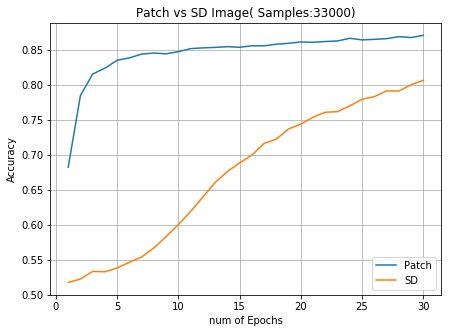

In [7]:
generate_graph(1, training_size_sd_plot, accuracy_patch, accuracy_sd, "Accuracy", "Patch", "SD Image", 33000)